In [1]:
import sys
sys.path.append('../')

import cv2
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from fddb_reader import *
from equi_augmentation import *
figsize(5, 5)

In [2]:
images = read_fold("../data/FDDB-folds/FDDB-fold-01-ellipseList.txt")

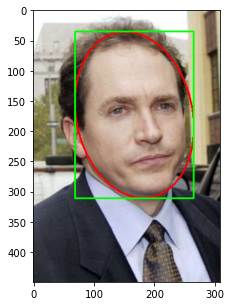

In [3]:
image = draw_image(images[210])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
b_points = get8boundingpointsy_x(images[210]['faces'][0]['bounding_box'])

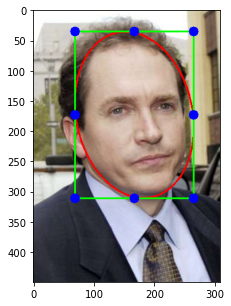

In [5]:
image_p = draw_points(image, b_points, color = (255,0,0))

plt.imshow(cv2.cvtColor(image_p, cv2.COLOR_BGR2RGB))
plt.show()